# Building an image similarity system with 🤗, Custom Datasets and FAISS

This notebook is adapted from HuggingFace's [Image Similarity with 🤗 Datasets and 🤗 Transformers](https://huggingface.co/blog/image-similarity) blog post. The original notebook can be found [here](https://colab.research.google.com/github/huggingface/notebooks/blob/main/examples/image_similarity.ipynb#scrollTo=fAYCqp0Ufx_V). This notebook is modified to work with custom datasets and intended for beginners to learn how to build an image similarity system with 🤗, custom datasets and FAISS.


## Install the required packages


In [ ]:
!pip install --upgrade pip
!pip install transformers datasets faiss-cpu -q


## Mount Google Drive

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

## Import the necessary packages

In [5]:
# from transformers import AutoFeatureExtractor, AutoModel
# from datasets import load_dataset, concatenate_datasets, load_from_disk
# from PIL import Image
# import numpy as np

## Load model for computing embeddings of the candidate images

In [6]:
model_ckpt = "google/vit-base-patch16-224"

extractor = AutoFeatureExtractor.from_pretrained(model_ckpt)
model = AutoModel.from_pretrained(model_ckpt)

hidden_dim = model.config.hidden_size

## Load candidate subset

1. Prepare your dataset of Images in the following format:

```
train
├── class1
│   ├── 1.jpg
│   ├── 2.jpg
│   └── 3.jpg
|   ...
├── class2
│   ├── 1.jpg
│   ├── 2.jpg
│   └── 3.jpg
|   ...
└── class3
    ├── 1.jpg
    ├── 2.jpg
    └── 3.jpg
    ...
```
Here, the name of the class1 can be anything and the name of the images can be anything. The only requirement is that the images should be in the ```jpg``` format. These class names would later reflect in the labels of the identified images.
2. Place the ```train``` folder in your Google Drive.

In [7]:
# load dataset from Google Drive
dataset = load_dataset("imagefolder", data_dir='/content/drive/MyDrive/train/')

candidate_dataset = dataset['train']

## Resize the images (if required)

In [4]:
# resize all PIL images to 224x224
for i, example in enumerate(candidate_dataset):
    candidate_dataset[i]['image'] = example['image'].resize((224, 224), Image.BILINEAR)

164


In [5]:
# labels to names mapping for visualization purposes
folder_names = candidate_dataset.features['label'].names

# assign labels to the images from the folder names
labels_to_names = {i: folder_names[i] for i in range(len(folder_names))}


## Extract embeddings

In [6]:
def extract_embeddings(image):
    image_pp = extractor(image, return_tensors="pt")
    features = model(**image_pp).last_hidden_state[:, 0].detach().numpy()
    return features.squeeze()

## Creating hashes for the embeddings using FAISS and saving the index

In [7]:

dataset_with_embeddings = candidate_dataset.map(lambda example: {'embeddings': extract_embeddings(example["image"])})

# save dataset with embeddings variable to disk 
dataset_with_embeddings.save_to_disk('old_embeddings')

# load dataset with embeddings from disk
dataset_with_embeddings.add_faiss_index(column='embeddings')

# save the faiss index to disk
dataset_with_embeddings.save_faiss_index('embeddings', 'old_index.faiss')


100%|██████████| 1/1 [00:00<00:00, 439.75it/s]                                             


## Loading Saved Datasets 

In [ ]:
# dataset_with_embeddings = load_from_disk('images/beverages_embeddings')
# dataset_with_embeddings.load_faiss_index('embeddings', 'images/beverages_index.faiss')

## Combining Datasets


Incase if you have extended your training data, you can directly load the saved datasets and combine them with the new dataset. This is done by using the ```datasets.load_from_disk``` function. The datasets are combined using the ```datasets.concatenate_datasets``` function. The combined dataset is then saved using the ```datasets.save_to_disk``` function.
*Make Sure* that the classes in the new dataset are the same as the classes in the saved dataset.

### First load the new dataset and create hashes for the embeddings

In [1]:
# Load the additional dataset
additional_dataset = load_dataset("imagefolder", data_dir='/content/drive/MyDrive/train/')

# Select the desired split from the additional dataset
additional_dataset = additional_dataset['train']

# Resize all PIL images to 224x224
for i, example in enumerate(additional_dataset):
    additional_dataset[i]['image'] = example['image'].resize((224, 224), Image.BILINEAR)

# Extract embeddings for the images in the additional dataset
additional_embeddings = additional_dataset.map(lambda example: {'embeddings': extract_embeddings(example["image"])})

### Combine the datasets

In [2]:

# Combine the existing dataset_with_embeddings and the additional embeddings
combined_dataset = concatenate_datasets([dataset_with_embeddings, additional_embeddings])

dataset_with_embeddings.save_to_disk('ew_embeddings')

# Add a Faiss index to the combined dataset
combined_dataset.add_faiss_index(column='embeddings')

# Save the combined dataset to disk
combined_dataset.save_faiss_index('embeddings', 'new_index.faiss')

## Select a random image to run the query(image search)

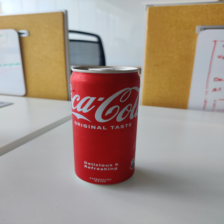

In [8]:
# load query_image from folder
query_image = Image.open('/content/drive/MyDrive/train/')

# resize query image to 224x224 (if required)
query_image = query_image.resize((224, 224), Image.BILINEAR)
# query_image = query_image.rotate(90, Image.NEAREST, expand = 1)

query_image

In [11]:
def image_grid(imgs, rows, cols):
    w,h = imgs[0].size
    grid = Image.new('RGB', size=(cols*w, rows*h))
    for i, img in enumerate(imgs): grid.paste(img, box=(i%cols*w, i//cols*h))
    return grid

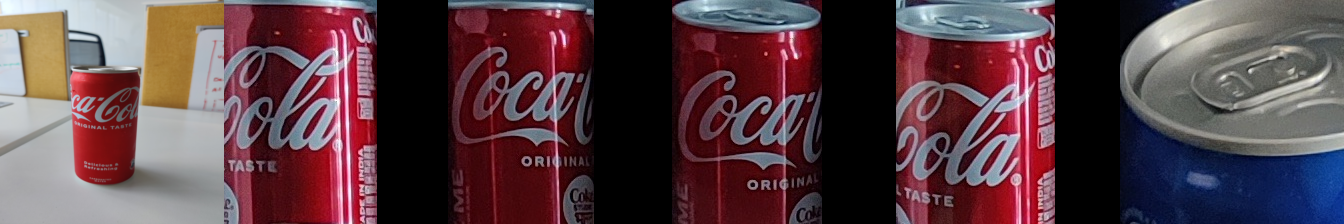

In [12]:
scores, retrieved_examples = get_neighbors(query_image)
images = [query_image]
images.extend(retrieved_examples["image"])

image_grid(images, 1, len(images))

In [4]:
# print names of retrieved images
names = np.array(retrieved_examples['label'])

## Logic for finding the majority label: Select the label that occurs the most number of times and if there is a tie, select the first one with higher similarity score
print()
if labels_to_names[names[0]] != labels_to_names[np.argmax(np.bincount(names))]:
    print(labels_to_names[names[0]])
else:
    print(labels_to_names[np.argmax(np.bincount(names))])
